In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.6 MB/s eta 0:00:00


In [3]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:

img = cv.imread("/content/drive/MyDrive/face_recognition/dataset/Taylor_swift/1.jpg")

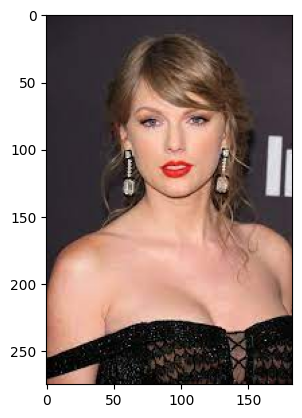

In [5]:
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

In [6]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
results = detector.detect_faces(img)

1/1 [==============================] - 0s 176ms/step


In [7]:
results

[{'box': [61, 43, 72, 93],
  'confidence': 0.99959796667099,
  'keypoints': {'left_eye': (78, 80),
   'right_eye': (112, 77),
   'nose': (95, 97),
   'mouth_left': (85, 114),
   'mouth_right': (109, 113)}}]

In [8]:
x,y,w,h = results[0]['box']

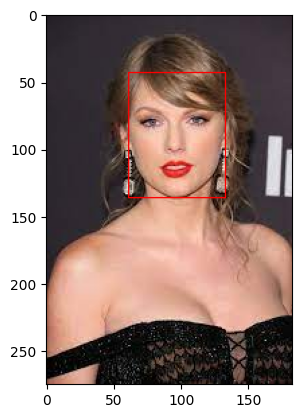

In [9]:
img = cv.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 0)
plt.imshow(img)

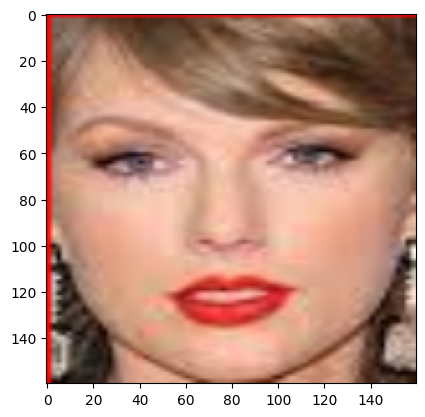

In [10]:
my_face = img[y:y+h, x:x+w]
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

In [11]:
my_face

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [246,   7,   6],
        [224,  23,  21],
        ...,
        [183,  14,   9],
        [184,  15,  10],
        [184,  15,  10]],

       [[255,   0,   0],
        [233,  17,  15],
        [176,  60,  54],
        ...,
        [ 71,  35,  23],
        [ 72,  38,  25],
        [ 73,  39,  26]],

       ...,

       [[255,   0,   0],
        [227,  15,  14],
        [157,  55,  49],
        ...,
        [ 53,  30,  15],
        [ 51,  28,  12],
        [ 50,  26,  11]],

       [[255,   0,   0],
        [218,   6,   5],
        [125,  23,  19],
        ...,
        [ 54,  30,  15],
        [ 50,  25,  10],
        [ 48,  23,   8]],

       [[255,   0,   0],
        [213,   1,   0],
        [104,   2,   0],
        ...,
        [ 55,  31,  15],
        [ 49,  24,   9],
        [ 47,  21,   6]]

#automate preprocessing 

In [12]:
class FACELOADING:
  def __init__(self, directory):
    self.directory = directory
    self.target_size = (160, 160)
    self.X = []
    self.Y = []
    self.detector = MTCNN()

  def extract_face(self, filename):
    img = cv.imread(filename)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    x,y,w,h = self.detector.detect_faces(img)[0]['box']
    x,y = abs(x), abs(y)
    face = img[y:y+h, x:x+w]
    face_arr = cv.resize(face, self.target_size)
    return face_arr

  def load_faces(self, dir):
    FACES = []
    for im_name in os.listdir(dir):
      try:
        path = dir + im_name
        single_face = self.extract_face(path)
        FACES.append(single_face)
      except Exception as e:
        pass
    return FACES

  def load_classes(self):
    for sub_dir in os.listdir(self.directory):
      path = self.directory +'/'+ sub_dir+'/'
      FACES = self.load_faces(path)
      labels = [sub_dir for _ in range(len(FACES))]
      print(f"Loaded successfully :{len(labels)}")
      self.X.extend(FACES)
      self.Y.extend(labels)

    return np.asarray(self.X), np.asarray(self.Y)

  def plot_images(self):
    plt.Figure(figsize=(18,12))
    for num,image in enumerate(self.X):
      ncols =3
      nrows = len(self.Y)//ncols
      plt.subplot(nrows,ncols,num+1)
      plt.imshow(image)
      plt.axis('off')

In [13]:
faceloading =FACELOADING("/content/drive/MyDrive/face_recognition/dataset")
X, Y = faceloading.load_classes()

1/1 [==============================] - 0s 118ms/step


1/1 [==============================] - 0s 35ms/step
Loaded successfully :10
1/1 [==============================] - 0s 49ms/step
Loaded successfully :10
1/1 [==============================] - 0s 43ms/step
Loaded successfully :10
1/1 [==============================] - 0s 36ms/step
Loaded successfully :9


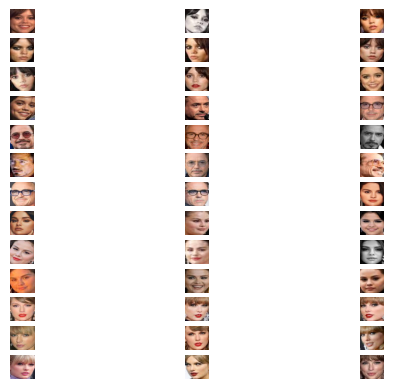

In [14]:
faceloading.plot_images()

FaceNet part

In [15]:
!pip install keras-facenet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10385 sha256=28cbc1c9291c46ebbb459337fe930543b1adaeab7dfca993090dbd0b2dff3ede
  Stored in directory: /root/.cache/pip/wheels/73/5d/41/90b5d28ca667cfc4748ae859fa4f0b85b936d73207a073ded5
Successfully built keras-facenet


In [16]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
  face_img = face_img.astype('float32')
  face_img = np.expand_dims(face_img, axis=0)
  yhat = embedder.embeddings(face_img)
  return yhat[0]

In [17]:
EMBEDDED_X = []

for img in X:
  EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 156ms/step


In [18]:
np.savez_compressed('faces_embeddings_done_4classes.npz', EMBEDDED_X,Y)

SVM model

In [19]:
Y

array(['Jenna_Ortega', 'Jenna_Ortega', 'Jenna_Ortega', 'Jenna_Ortega',
       'Jenna_Ortega', 'Jenna_Ortega', 'Jenna_Ortega', 'Jenna_Ortega',
       'Jenna_Ortega', 'Jenna_Ortega', 'Robert_Downey', 'Robert_Downey',
       'Robert_Downey', 'Robert_Downey', 'Robert_Downey', 'Robert_Downey',
       'Robert_Downey', 'Robert_Downey', 'Robert_Downey', 'Robert_Downey',
       'Selena_Gomez', 'Selena_Gomez', 'Selena_Gomez', 'Selena_Gomez',
       'Selena_Gomez', 'Selena_Gomez', 'Selena_Gomez', 'Selena_Gomez',
       'Selena_Gomez', 'Selena_Gomez', 'Taylor_swift', 'Taylor_swift',
       'Taylor_swift', 'Taylor_swift', 'Taylor_swift', 'Taylor_swift',
       'Taylor_swift', 'Taylor_swift', 'Taylor_swift'], dtype='<U13')

In [20]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

In [21]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [22]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train, Y_test = train_test_split(EMBEDDED_X, Y,shuffle = True, random_state=17)

In [23]:
from sklearn.svm import SVC
model = SVC(kernel='linear',probability=True)
model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [24]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [25]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train)

1.0

In [26]:
accuracy_score(Y_test, ypreds_test)

1.0

In [27]:
t_im = cv.imread("/content/drive/MyDrive/face_recognition/taylor_test.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

1/1 [==============================] - 0s 52ms/step


In [28]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

1/1 [==============================] - 0s 173ms/step


In [29]:
test_im = [test_im]
ypreds = model.predict(test_im)

In [30]:
ypreds

array([3])

In [31]:
encoder.inverse_transform(ypreds)

array(['Taylor_swift'], dtype='<U13')

In [32]:
import pickle

with open('svm_model.pkl','wb') as f:
  pickle.dump(model,f)